In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from data.data import Data
from models.double_mlp import DoubleMLPEstimator
from models.estimate import prop_dml
from tqdm.notebook import tqdm
from wrap.utils import np_to_torch, torch_to_np


p = 20
n = 200
rho = 0
theta = 1
lamb = 1

In [10]:
def run_experiments(theta, lambds, num_exp=10):
    df = pd.DataFrame()
    for lamb in tqdm(lambds):
        for i in range(num_exp):
            true_model = Data(p, rho, theta, lamb)
            Y, D, X = true_model.generate(n)
            theta_hat, dm_dl, dm2, bias, v2 = prop_dml(Y, D, X, true_model, reg_labmda=1)
            df_tmp = pd.DataFrame({'model' : ['mlp'],
                                    'rho' : rho,
                                    'lamb' : lamb,
                                    'theta' : theta,
                                    'theta.hat' : theta_hat,
                                    'dtheta' : theta_hat - theta,
                                    'bias' : bias/v2,
                                    'dm.dl' : dm_dl/v2,
                                    'dm2' : dm2/v2
                                    })
            df = pd.concat([df, df_tmp])
    
    return df

lambds = np.linspace(-0.5, 0.5, 11, endpoint=True)
df = run_experiments(theta, lambds, num_exp=100)
df_avg = df.groupby(['model', 'rho', 'lamb', 'theta']).mean().reset_index()

  0%|          | 0/11 [00:00<?, ?it/s]

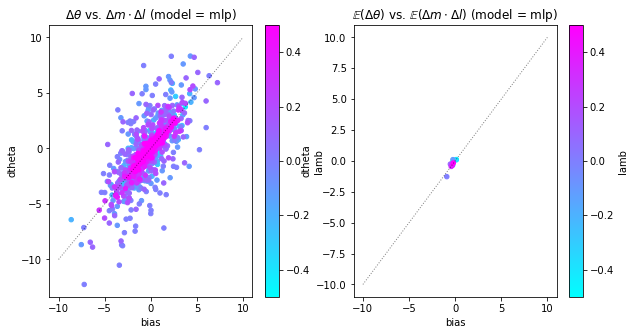

In [11]:
def plot_results(df, axs):
    df_tmp = df[df['model'] == 'mlp']
    df_tmp.plot.scatter(x='bias', y='dtheta', c='lamb', cmap=cm, ax=axs)
    axs.plot([-10, 10], [-10, 10], color='black', alpha=0.5, linewidth=1, linestyle=':')

cm = plt.cm.get_cmap('cool')
_, axs = plt.subplots(1, 2, figsize=(10,5)) 

plot_results(df, axs[0])
axs[0].set_title('$\\Delta \\theta$ vs. $\\Delta m \cdot \\Delta l$ (model = mlp)')

plot_results(df_avg, axs[1])
axs[1].set_title('$\mathbb{E}(\\Delta \\theta$) vs. $\mathbb{E}(\\Delta m \cdot \\Delta l)$ (model = mlp)')

plt.savefig('results/ours_bias_' + str(theta) + '_.pdf', bbox_inches='tight')
plt.show()

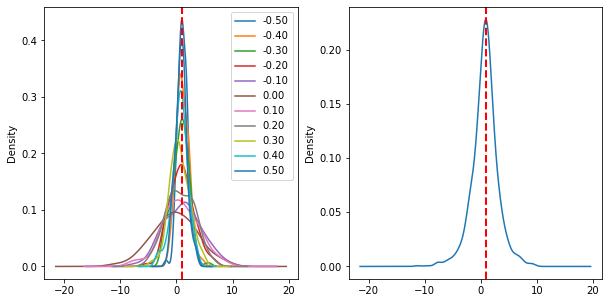

In [12]:
_, axs = plt.subplots(1, 2, figsize=(10,5)) 
for lamb in lambds:
    df_tmp = df[df['lamb'] == lamb]
    df_tmp['theta.hat'].plot.kde(ax=axs[0], label='{:.2f}'.format(lamb))
axs[0].legend()
axs[0].axvline(x=theta, linestyle='--', linewidth=2., color='red')

df['theta.hat'].plot.kde(ax=axs[1])
axs[1].axvline(x=theta, linestyle='--', linewidth=2., color='red')

plt.savefig('results/ours_theta_' + str(theta) + '_.pdf', bbox_inches='tight')
plt.show()